# Abstract

# Loading The Model and Packages

Source Code: 

# Considering p > n For Linear Regression

When the number of features $p$ exceeds the number of data observations $n$, the standard closed-form solution for linear regression becomes invalid due to an issue involving matrix invertibility. The formula $\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ relies on the inversion of the matrix $\mathbf{X}^T\mathbf{X}$. However, when $p > n$, the matrix $\mathbf{X}$ has more columns than rows, making $\mathbf{X}^T\mathbf{X}$ a $p \times p$ matrix that is not full rank. This means it is singular, or rank-deficient, and therefore not invertible. As a result, the operation $(\mathbf{X}^T\mathbf{X})^{-1}$ is undefined, and the entire expression for $\hat{\mathbf{w}}$ in Equation 1 breaks down. This is why the closed-form solution is only valid when $n > p$, ensuring that $\mathbf{X}^T\mathbf{X}$ is invertible.


# Loading the Model and Packages

In [24]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from OverparametrizedRegression import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
plt.style.use('seaborn-v0_8-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Model on Simple Data

In [5]:
# First we will define a class to generate random feature maps
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

To test our model we will fit nonlinear data using our random features class and feed these features to our LinearRegression model. We will then plot our predictions overtop the data.

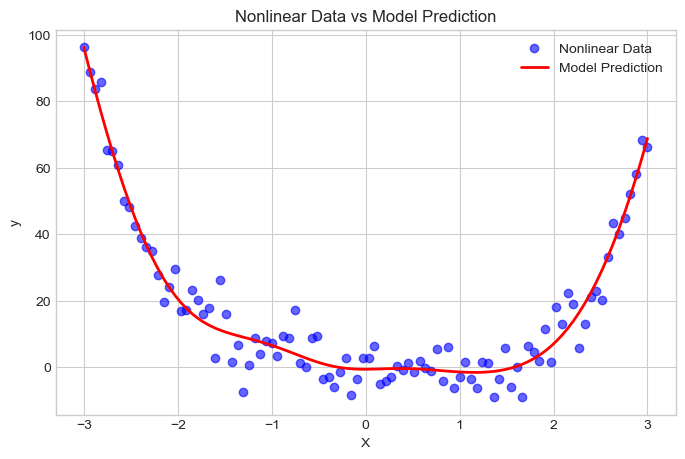

In [ ]:
# Generate Nonlinear Data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

# transorm our data
phi = RandomFeatures(n_features = 10)
phi.fit(X)
phi_X = phi.transform(X)

# instantiate our model and optimizer
LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)

# fit the model to our transformed data
opt.fit(phi_X, y)

# pull predictions from the data
y_pred = LR.predict(phi_X)

# Plot predictions vs actual data
plt.figure(figsize = (8, 5))
plt.scatter(X, y, label = 'Nonlinear Data', color = 'blue', alpha = 0.6)
plt.plot(X, y_pred, label = 'Model Prediction', color = 'red', linewidth = 2)
plt.title("Nonlinear Data vs Model Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Just based off preliminary predictions on training data is appears as if our overparametrized model is performing well. Lets continue on to explore how this model performs more in depth.

# Double Descent in Image Corruption Detection

To perform image corruption detections we will load a greyscale image of a flower and then replace some of the pixels with completely grey chunks to represent corruption of the image. We will then attempt to use our model to predict the number of corruptions in the image based on the image itself. Lets start by loading the image and corrupting it. 

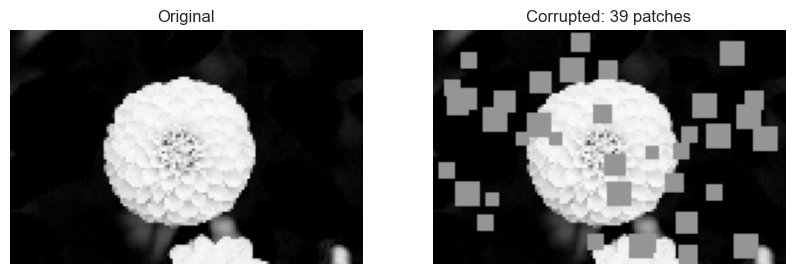

In [22]:
# load our flower image
dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

# define a function to corrupt the image
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

# use our function to load and corrupt the flower image and view the new image side by side with the natural image
X, y = corrupted_image(flower, mean_patches = 50)

# Show original and corrupted side by side
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(flower)  
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(X, vmin = 0, vmax=1)  # Keep value range, don't force colormap
ax[1].set_title(f"Corrupted: {y} patches")
ax[1].axis("off")

plt.show()

Now that we have a method to generate corrupted flowers with varying levels of corruption, we will generate a dataset of 200 samples of corrupted images and split into testing and training data.

In [ ]:
# set 200 samples as our benchmark dataset size
n_samples = 200

# generate 200 corrupted images
X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

# Reshape the images to lay them out into long rows
X = X.reshape(n_samples, -1)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

# Discussion